In [14]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

pd.options.display.max_columns = 99
plt.rcParams['figure.figsize'] = (12, 8)

In [15]:
df_train = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/train.csv', parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/test.csv', parse_dates=['date'], index_col=['date'])
df_train.shape, df_test.shape

((913000, 3), (45000, 3))

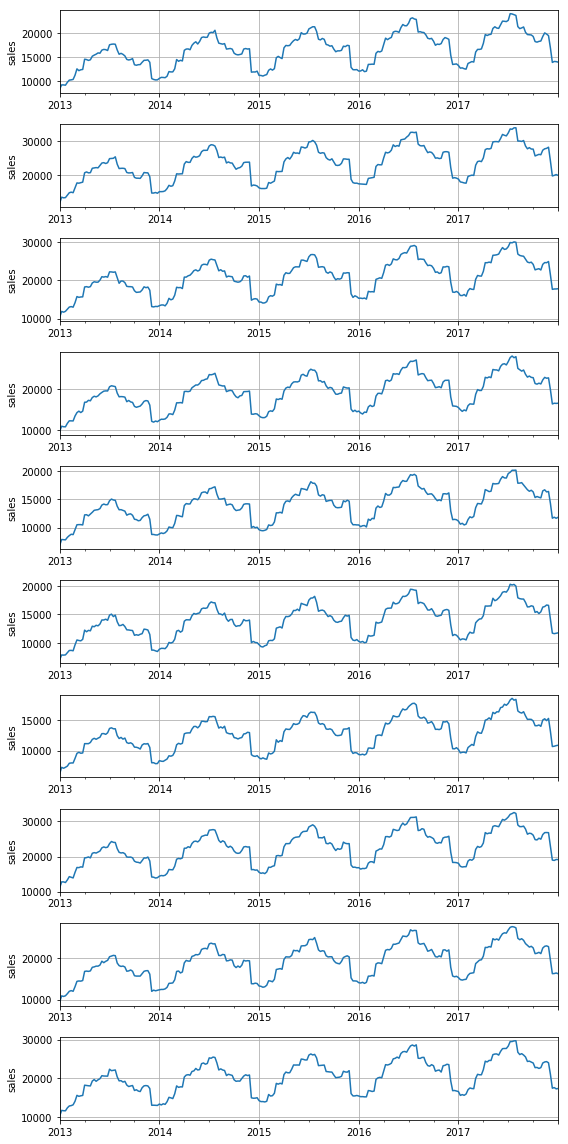

In [16]:
num_stores = len(df_train['store'].unique())
fig, axes = plt.subplots(num_stores, figsize=(8, 16))

for s in df_train['store'].unique():
    t = df_train.loc[df_train['store'] == s, 'sales'].resample('W').sum()
    ax = t.plot(ax=axes[s-1])
    ax.grid()
    ax.set_xlabel('')
    ax.set_ylabel('sales')
fig.tight_layout();

In [17]:
s1i1 = df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 1)]
s1i1.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


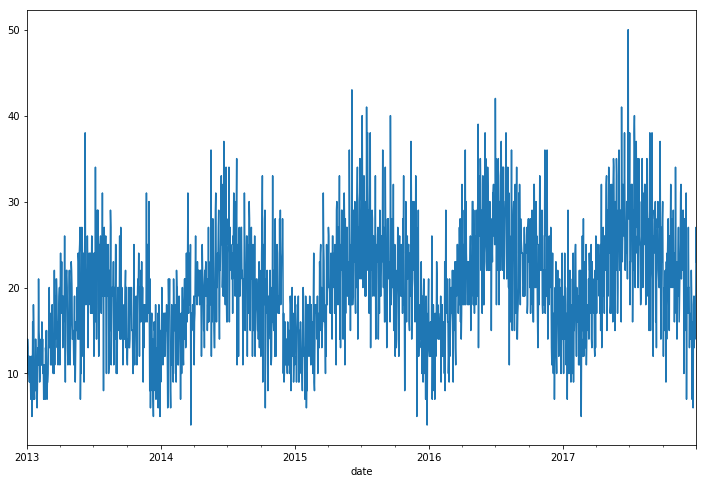

In [18]:
s1i1['sales'].plot();

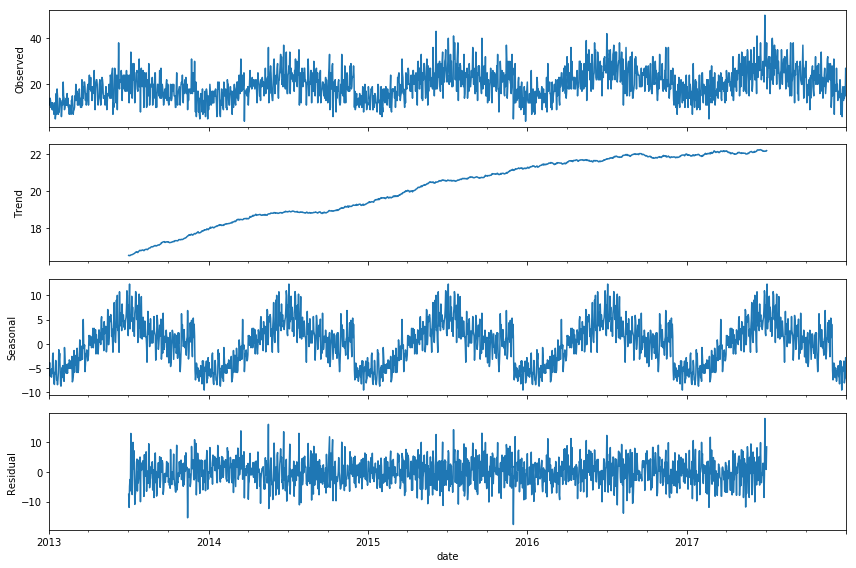

In [19]:
fig = seasonal_decompose(s1i1['sales'], model='additive', freq=365).plot()

In [20]:
dftest = adfuller(s1i1['sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64

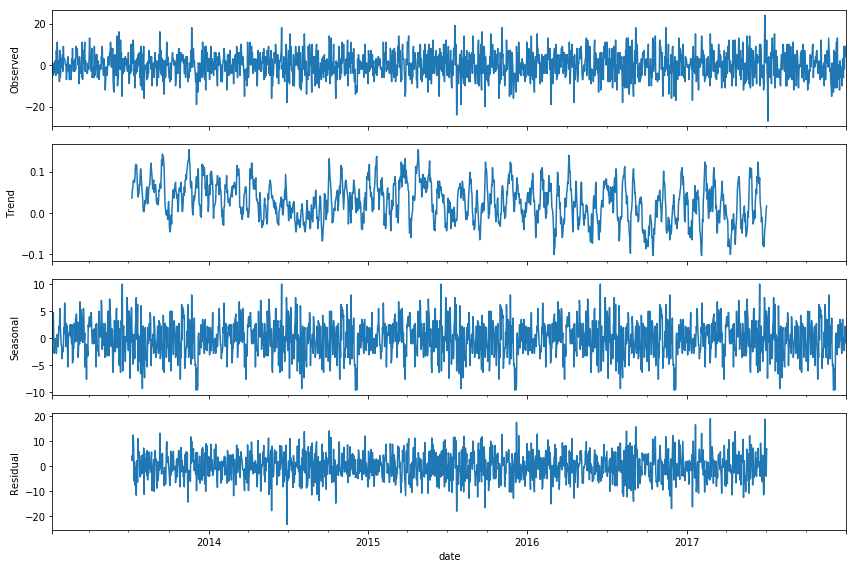

In [21]:
diff_7 = s1i1['sales'].diff(7)
diff_7.dropna(inplace=True)
fig = seasonal_decompose(diff_7, model='additive', freq=365).plot()

In [22]:
dftest = adfuller(diff_7, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.944407e+00
p-value                        9.070149e-15
#Lags Used                     2.400000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64

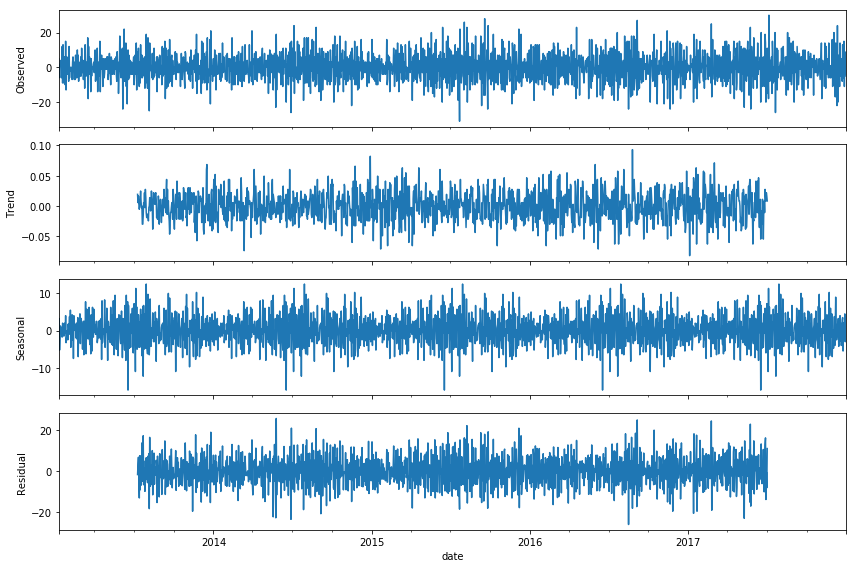

In [23]:
diff_1_7 = diff_7.diff(1)
diff_1_7.dropna(inplace=True)
fig = seasonal_decompose(diff_1_7, model='additive', freq=365).plot()

In [24]:
dftest = adfuller(diff_1_7, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.762274e+01
p-value                        3.831626e-30
#Lags Used                     2.500000e+01
Number of Observations Used    1.792000e+03
Critical Value (1%)           -3.434004e+00
Critical Value (5%)           -2.863154e+00
Critical Value (10%)          -2.567629e+00
dtype: float64

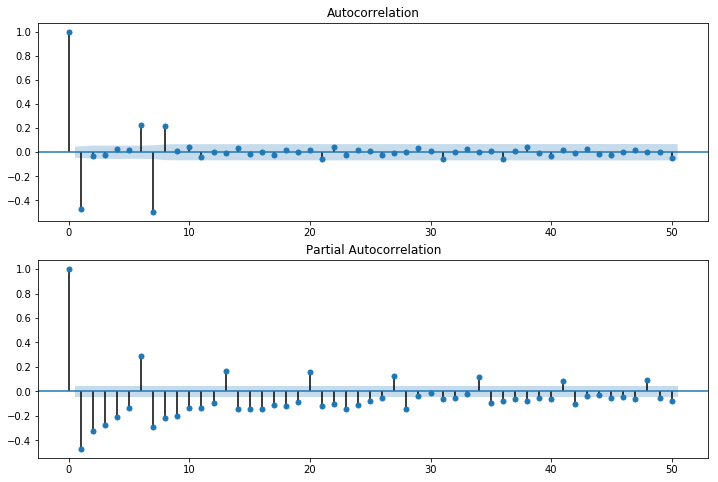

In [25]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(diff_1_7, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(diff_1_7, lags=50, ax=ax[1])

In [26]:
sarima = sm.tsa.statespace.SARIMAX(s1i1['sales'], trend='n', freq='D', enforce_invertibility=False,
                                   order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
results = sarima.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5393.681
Date:                           Sat, 09 Nov 2019   AIC                          10807.362
Time:                                   14:47:58   BIC                          10862.416
Sample:                               01-01-2013   HQIC                         10827.674
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050      0.035      0.145      0.885      -0.063       0.073
ar.L2         -0.0292      0.031     -0.942

C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


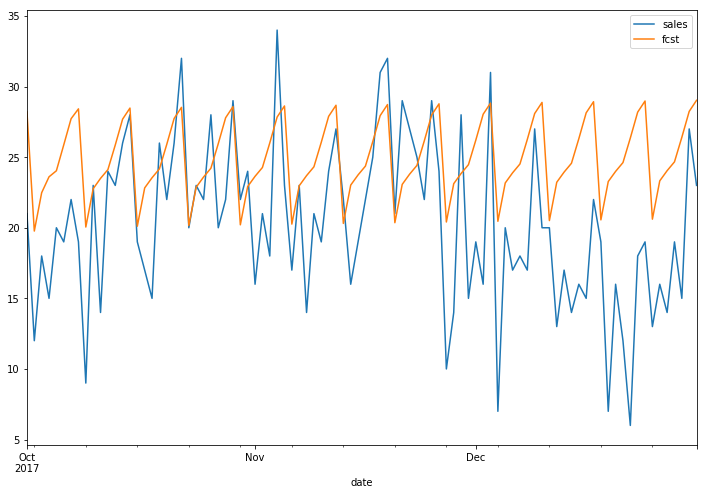

In [27]:
s1i1['fcst'] = results.predict(start='2017-10-01', end='2017-12-31', dynamic=True)
s1i1[['sales', 'fcst']].loc['2017-10-01':].plot();

In [28]:
sarima_results = df_test.reset_index()
sarima_results['sales'] = 0

In [29]:
tic = time.time()

for s in sarima_results['store'].unique():
    for i in sarima_results['item'].unique():
        si = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i), 'sales']
        sarima = sm.tsa.statespace.SARIMAX(si, trend='n', freq='D', enforce_invertibility=False,
                                           order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = sarima.fit()
        fcst = results.predict(start='2017-12-31', end='2018-03-31', dynamic=True)
        sarima_results.loc[(sarima_results['store'] == s) & (sarima_results['item'] == i), 'sales'] = fcst.values[1:]
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}s".format(s, i, toc-tic))

Completed store 1 item 10. Cumulative time: 122.7s
Completed store 1 item 20. Cumulative time: 229.0s
Completed store 1 item 30. Cumulative time: 337.9s
Completed store 1 item 40. Cumulative time: 449.3s
Completed store 1 item 50. Cumulative time: 571.7s
Completed store 2 item 10. Cumulative time: 680.1s
Completed store 2 item 20. Cumulative time: 802.4s
Completed store 2 item 30. Cumulative time: 946.1s
Completed store 2 item 40. Cumulative time: 1060.5s
Completed store 2 item 50. Cumulative time: 1162.6s
Completed store 3 item 10. Cumulative time: 1278.5s
Completed store 3 item 20. Cumulative time: 1393.0s


C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 3 item 30. Cumulative time: 1513.8s
Completed store 3 item 40. Cumulative time: 1620.4s
Completed store 3 item 50. Cumulative time: 1736.9s
Completed store 4 item 10. Cumulative time: 1861.1s
Completed store 4 item 20. Cumulative time: 1969.9s
Completed store 4 item 30. Cumulative time: 2093.5s
Completed store 4 item 40. Cumulative time: 2213.8s
Completed store 4 item 50. Cumulative time: 2330.8s


C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 5 item 10. Cumulative time: 2454.3s
Completed store 5 item 20. Cumulative time: 2561.4s
Completed store 5 item 30. Cumulative time: 2678.4s
Completed store 5 item 40. Cumulative time: 2782.0s
Completed store 5 item 50. Cumulative time: 2908.9s
Completed store 6 item 10. Cumulative time: 3023.5s
Completed store 6 item 20. Cumulative time: 3131.5s
Completed store 6 item 30. Cumulative time: 3245.4s
Completed store 6 item 40. Cumulative time: 3359.5s
Completed store 6 item 50. Cumulative time: 3472.6s
Completed store 7 item 10. Cumulative time: 3584.7s


C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 7 item 20. Cumulative time: 3710.5s
Completed store 7 item 30. Cumulative time: 3823.0s
Completed store 7 item 40. Cumulative time: 3937.2s
Completed store 7 item 50. Cumulative time: 4048.9s
Completed store 8 item 10. Cumulative time: 4163.1s


C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 8 item 20. Cumulative time: 4282.2s
Completed store 8 item 30. Cumulative time: 4403.4s
Completed store 8 item 40. Cumulative time: 4520.9s
Completed store 8 item 50. Cumulative time: 4645.0s
Completed store 9 item 10. Cumulative time: 4767.8s
Completed store 9 item 20. Cumulative time: 4886.0s
Completed store 9 item 30. Cumulative time: 5021.2s
Completed store 9 item 40. Cumulative time: 5131.7s
Completed store 9 item 50. Cumulative time: 5246.1s
Completed store 10 item 10. Cumulative time: 5349.5s
Completed store 10 item 20. Cumulative time: 5461.4s
Completed store 10 item 30. Cumulative time: 5573.6s


C:\Users\PriyaN\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 10 item 40. Cumulative time: 5702.8s
Completed store 10 item 50. Cumulative time: 5810.2s


In [34]:
sarima_results.head()

,id,sales
0,0,12.172828
1,1,14.936746
2,2,15.549178
3,3,16.577055
4,4,17.682020


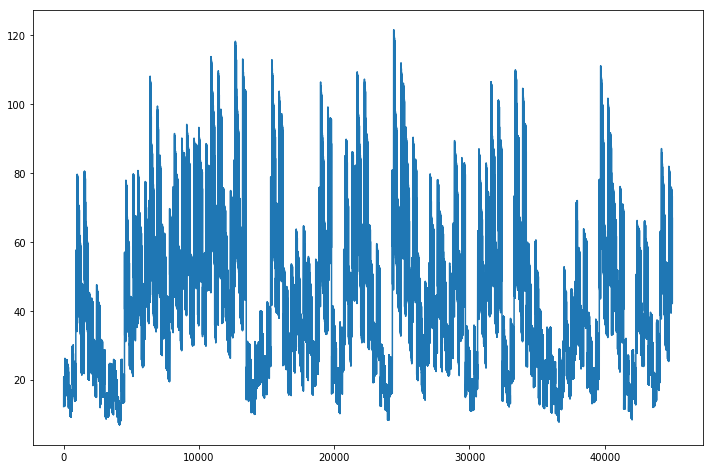

In [35]:
plt.plot(sarima_results.id,sarima_results.sales)
plt.show()

In [36]:

sarima_results.to_csv('sarima_results.csv', index=False)